In [1]:
library(readxl)
install.packages("gsheet")
library(tidyverse)
library(repr)
library(digest)
library(infer)
library(cowplot)
library(broom)
library(GGally)
library(AER)
library(gsheet)
library(gridExtra)
library(leaps)
library(glmnet)
library(mltools)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.4     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   2.0.1     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Loading required package: car

Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode


The following object is masked from ‘package:purrr’:

    some


Loading required package: lmtest

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: sandwich

Loading req

In [2]:
# set seed for notebook
set.seed(7777)

# How Spotify Song Attributes Affect Valence

## Introduction


Starting from infancy and all throughout one's life, listening to music is an activity that the majority of people engage in. Music has been shown to have effects on our daily functioning and overall well-being (Groarke & Hogan, 2018). In particular, how positive or how negative a song sounds plays a critical role in determining how someone will be affected by listening to it. For example, listening to positive sounding music increases self-confidence (Tajadura-Jiménez, 2011) and can help relieve pain (Roy, Peretz, & Rainville, 2008). This musical positiveness present in a song is called its valence, so a song that sounds cheerful and upbeat is said to have high valence. 

Music today is becoming more and more accessible as people can choose what they listen to on the radio, youtube, or on one of the many available streaming services. Currently, Spotify is the world’s most popular music streaming service with over 365 million monthly users (2021). We will be using a dataset containing 232725 songs available on Spotify that contains information about each song such as its genre, danceability, loudness, acousticness, and valence(among others). Our goals are to predict the valence of a song from its other attributes and determine what qualities of a song impact our emotional perception. Therefore, our project will focus on both inference and prediction. First, we will determine which features of the song are most related to its valence, and using these features as our explanatory variables, we will try to build a model to predict a song’s valence.





# Methods & Results

## Preliminary Data Analysis

In [3]:
# Read in the data and drop any na values in the dataset.
df <- gsheet2tbl('https://docs.google.com/spreadsheets/d/1fnNjFKFZmGgavOYezz-swtQICqWyAMMZxs2H6Nsk29M/edit#gid=2110346216')
df = drop_na(df)
print("Table 1 - Spotify Dataset")
head(df)


[1] "Table 1 - Spotify Dataset"


genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>
Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.611,0.389,99373,0.9100,0.000,C#,0.3460,-1.828,Major,0.0525,166.969,4/4,0.814
Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.246,0.590,137373,0.7370,0.000,F#,0.1510,-5.559,Minor,0.0868,174.003,4/4,0.816
Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3,0.952,0.663,170267,0.1310,0.000,C,0.1030,-13.879,Minor,0.0362,99.488,5/4,0.368
Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf,0,0.703,0.240,152427,0.3260,0.000,C#,0.0985,-12.178,Major,0.0395,171.758,4/4,0.227
Movie,Fabien Nataf,Ouverture,0IuslXpMROHdEPvSl1fTQK,4,0.950,0.331,82625,0.2250,0.123,F,0.2020,-21.150,Major,0.0456,140.576,4/4,0.390
Movie,Henri Salvador,Le petit souper aux chandelles,0Mf1jKa8eNAf1a4PwTbizj,0,0.749,0.578,160627,0.0948,0.000,C#,0.1070,-14.970,Major,0.1430,87.479,4/4,0.358


In [4]:
# Select relevant features from the dataset, removing metadata such as artist_name, track_name etc.
spotify = df %>% select(-artist_name,  -track_name, -track_id, -duration_ms)
print("Table 2 - Spotify Dataset without metadata")
head(spotify)

[1] "Table 2 - Spotify Dataset without metadata"


genre,popularity,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>
Movie,0,0.611,0.389,0.9100,0.000,C#,0.3460,-1.828,Major,0.0525,166.969,4/4,0.814
Movie,1,0.246,0.590,0.7370,0.000,F#,0.1510,-5.559,Minor,0.0868,174.003,4/4,0.816
Movie,3,0.952,0.663,0.1310,0.000,C,0.1030,-13.879,Minor,0.0362,99.488,5/4,0.368
Movie,0,0.703,0.240,0.3260,0.000,C#,0.0985,-12.178,Major,0.0395,171.758,4/4,0.227
Movie,4,0.950,0.331,0.2250,0.123,F,0.2020,-21.150,Major,0.0456,140.576,4/4,0.390
Movie,0,0.749,0.578,0.0948,0.000,C#,0.1070,-14.970,Major,0.1430,87.479,4/4,0.358


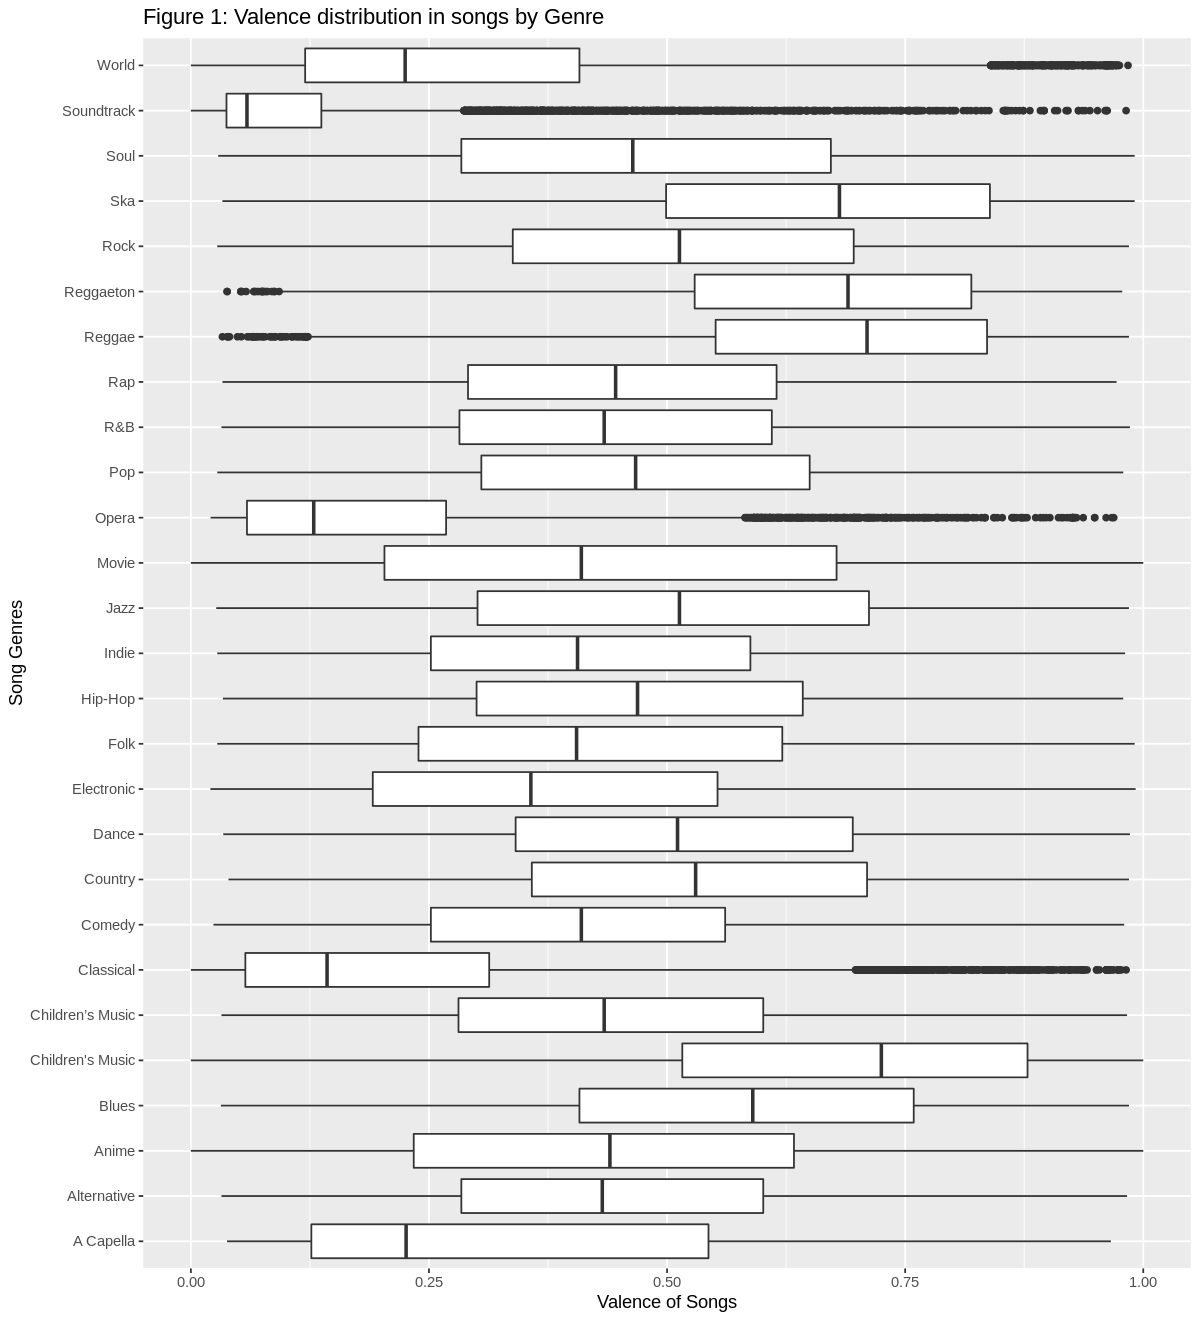

In [5]:
# Visualise the distribution of valence across all genres
# Note that the response variable is on the x-axis, this was done because due to the amount of different genres, having genre on the x axis
# made the labels difficult to read, even with rotated text.
options(repr.plot.width = 10, repr.plot.height = 11)
genre_plot = df %>%
ggplot() +
geom_boxplot(aes(y = genre, x = valence)) + 
labs(x = "Valence of Songs", y = "Song Genres", title = "Figure 1: Valence distribution in songs by Genre")

genre_plot



We have a wide variety of distributions for valence over different levels of genre, so it might be worthwhile to explore how the relationship between our predictive variables and the response is affected by genre

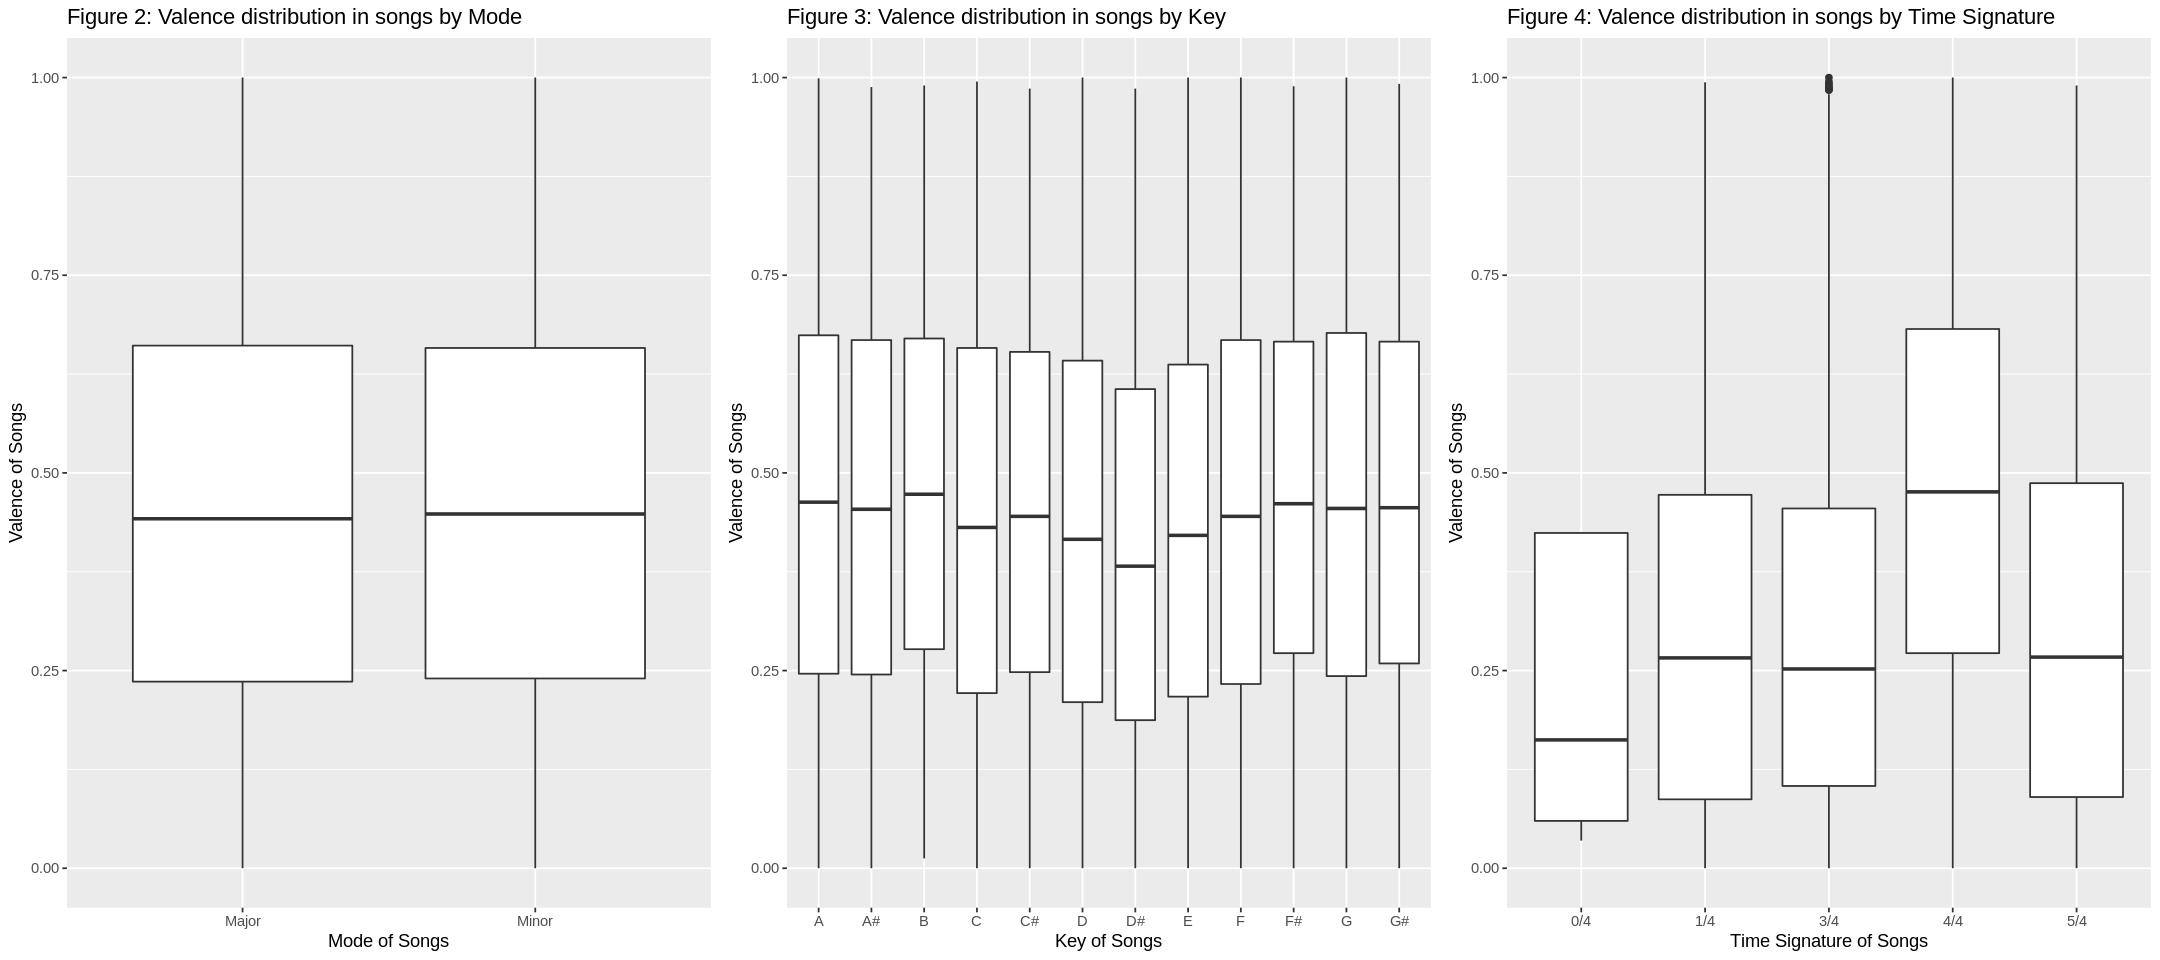

In [6]:
# Visualise the distribution of valence among different levels of categorical features, note that the response variable(valence) is plotted on the y axis from here onwards
options(repr.plot.width = 18, repr.plot.height = 8)
mode_plot = spotify %>%
ggplot() +
geom_boxplot(aes(y = valence, x = mode)) + 
labs(x = "Mode of Songs", y = "Valence of Songs", title = "Figure 2: Valence distribution in songs by Mode")

key_plot = spotify %>%
ggplot() +
geom_boxplot(aes(y = valence, x = key)) + 
labs(x = "Key of Songs", y = "Valence of Songs", title = "Figure 3: Valence distribution in songs by Key")

t_plot = spotify %>%
ggplot() +
geom_boxplot(aes(y = valence, x = time_signature)) + 
labs(x = "Time Signature of Songs", y = "Valence of Songs", title = "Figure 4: Valence distribution in songs by Time Signature")


 plot_grid(mode_plot, key_plot, t_plot,
   ncol = 3
 )


The distribution of valence seems almost identical across different modes, varies slightly across different keys, and varies moderately across different time signatures.

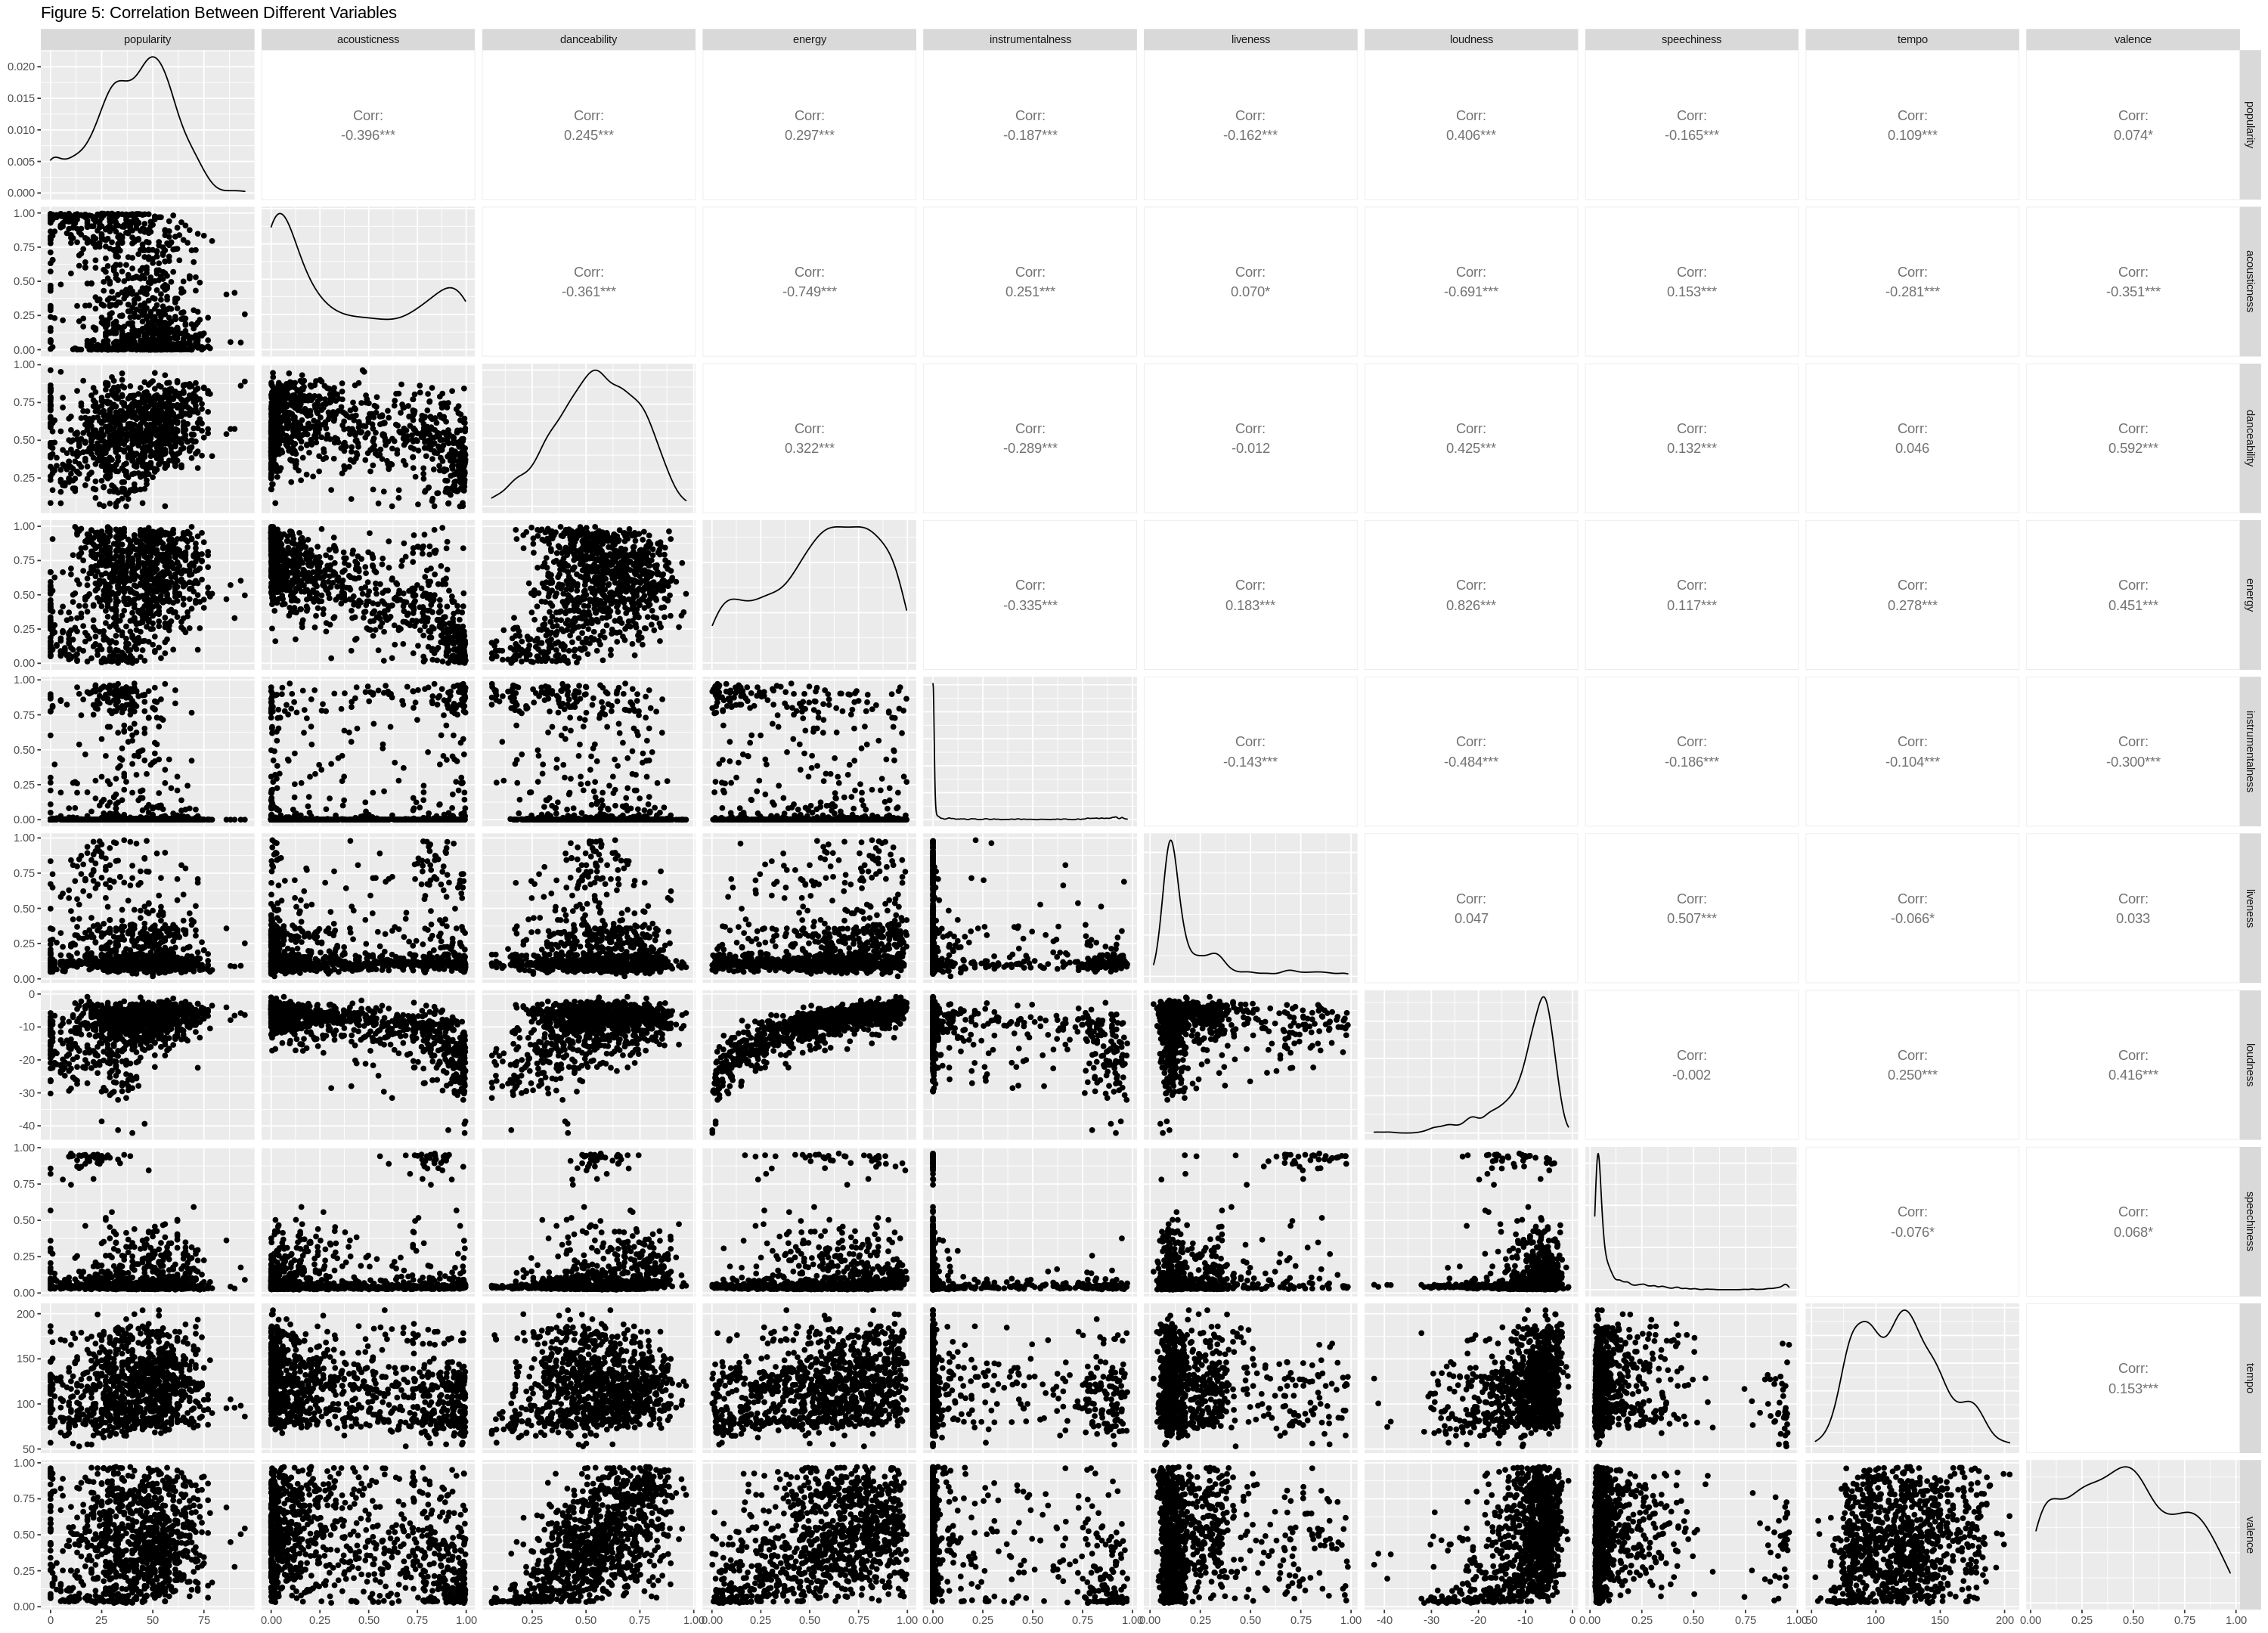

In [7]:
# Visualise the correlation between valence and numeric variables
# Note that running ggpairs with all the numeric variables was causing the kernel to timeout, so a random subsample of 1000 was used for visualization purposes
options(repr.plot.width = 25, repr.plot.height = 18)
pairs_plot = spotify %>%
            select(-genre, -key, -mode, -time_signature) %>%
            sample_n(size = 1000, replace = FALSE) %>%
            ggpairs(lower=list(combo=wrap("facethist", binwidth=0.8))) + ggtitle("Figure 5: Correlation Between Different Variables")

pairs_plot

Energy and loudness appear to be highly positively correlated (0.826) compared to the rest of the variables.

In [ ]:
# Creating a correlation matrix to examine the relationship between predictive variables
corr_matrix_sample <- spotify %>%
  select(-genre, -key, -mode, -time_signature) %>%
  cor() %>%
  as.data.frame() %>%
  rownames_to_column("var1") %>%
  pivot_longer(-var1, names_to = "var2", values_to = "corr")

plot_corr_matrix_sample <- corr_matrix_sample %>%
  ggplot(aes(x = var1, y = var2)) +
  geom_tile(aes(fill = corr), color = "white") +
  scale_fill_distiller("Correlation Coefficient \n",
    palette = 'YlOrRd',
    direction = 1, limits = c(-1, 1)
  ) +
  labs(x = "", y = "", title = "Figure 6. Correlational Matrix Heatmap") +
  theme_minimal() +
  theme(
    axis.text.x = element_text(
      angle = 45, vjust = 1,
      size = 18, hjust = 1
    ),
    axis.text.y = element_text(
      vjust = 1,
      size = 18, hjust = 1
    ),
    legend.title = element_text(size = 18, face = "bold"),
    legend.text = element_text(size = 18),
    legend.key.size = unit(2, "cm")
  ) +
  coord_fixed() +
  geom_text(aes(x = var1, y = var2, label = round(corr, 2)), color = "black", size = 6)
plot_corr_matrix_sample

To determine if loudness and energy may be contributing to multicollinearity, we will first perform feature selection to see if they are relevant for predicting valence. Then, based on the Variance Inflation Factors, we will assess which model may be most effective for predicting new song valences.

## Variable Selection

In [ ]:
# Removing categorical variables in the dataset, while it would have been nice to include these, our kernel 
# would either end up dying when we tried to fit our models or the output would be too complex to interpret due to the 
# amount of levels they introduced.
spotify <- spotify %>% select(-genre, -key, -mode, -time_signature)

# Splitting the dataset to avoid bias
spotify_split <- sample(rep(1:3, diff(floor(nrow(spotify) * c(0, 0.6, 0.8, 1)))))

# For the model
inference <- spotify[spotify_split==1,]

# For variable selection
selection <- spotify[spotify_split==2,]

# For testing our model
prediction_df <- spotify[spotify_split==3,]

In [ ]:
print("Table 3: Dataset for Feature Selection")
head(selection)

In [ ]:
#Run feature selection, using both forward and backward selection
spotify_sample_forward <- regsubsets(
  x = valence ~.,
  data = selection, nvmax = 50, method = "forward",
)

fwd_summary <- summary(spotify_sample_forward)

fwd_summary_df <- data.frame(
    RSQ = fwd_summary$rsq,
    RSS = fwd_summary$rss,
    ADJ.R2 = fwd_summary$adjr2,
    BIC = fwd_summary$bic
)

spotify_sample_backward <- regsubsets(
  x = valence ~.,
  data = selection, nvmax = 50, method = "backward",
)


back_summary <- summary(spotify_sample_backward)

back_summary_df <- data.frame(
    RSQ = back_summary$rsq,
    RSS = back_summary$rss,
    ADJ.R2 = back_summary$adjr2,
    BIC = back_summary$bic
)
print("Table 3: Summary of Models with different number of input variables selected by forward selection")
fwd_summary_df
print("Table 4: Summary of Models with different number of input variables selected by backward selection")
back_summary_df

In [ ]:
# Making scatter graphs to compare mallow's cp for the different models, so that we can pick the one with least apparent bias.
fwd_candidates <- tibble(
  n_input_variables = 1:9,
  C_p = fwd_summary$cp
)
fwd_plot = fwd_candidates %>%
            ggplot() +
            geom_point(aes(y = C_p, x = n_input_variables)) +
            labs(x = "Number of Input Variables",
                y = "Mallows' CP", 
                title = "Figure 7: Mallows' CP for Models with different number of input variables selected by forward selection")


back_candidates <- tibble(
  n_input_variables = 1:9,
  C_p = back_summary$cp
)
back_plot =  back_candidates %>%
            ggplot() +
            geom_point(aes(y = C_p, x = n_input_variables)) +
            labs(x = "Number of Input Variables",
                y = "Mallows' CP",
                title = "Figure 8: Mallows' CP Models with different number of input variables selected by backward selection")

 plot_grid(fwd_plot, back_plot,
   ncol = 2
 )

Looking at these values, we can see that Mallow's cp is lowest with all the predictors whether we do forward or backward selection, thus we will not remove any variables from our model.

### Variable Selection using Lasso

In [ ]:
# Running Feature selection using Lasso
lasso_model <-
    cv.glmnet(x = selection %>% select(-valence) %>% as.matrix(), 
              y = selection %>% select(valence) %>% as.matrix(), 
              alpha = 1)
plot(lasso_model, main = "Figure 9. Lambda selection by CV with LASSO")

### Feature Selection using Ridge

In [ ]:
# Running Feature selection using Ridge
ridge_model <-
    cv.glmnet(x = selection %>% select(-valence) %>% as.matrix(), 
              y = selection %>% select(valence) %>% as.matrix(), 
              alpha = 0)
plot(ridge_model, main = "Figure 10. Lambda selection by CV with Ridge")

In [ ]:
# Full model via ordinary least squares
full_model <- lm(valence ~ ., data = selection)

# Obtain coefficients for lambda which gives us lowest MSE
min_lasso_model <- glmnet(
    x = selection %>% select(-valence) %>% as.matrix(),
    y = selection %>% select(valence) %>% as.matrix(),
    alpha = 1,
    lambda = lasso_model$lambda.min)

min_lasso_model.coef <- min_lasso_model$beta

min_ridge_model <- glmnet(
    x = selection %>% select(-valence) %>% as.matrix(),
    y = selection %>% select(valence) %>% as.matrix(),
    alpha = 0,
    lambda = ridge_model$lambda.min)

min_ridge_model.coef <- min_ridge_model$beta

model_coefs <- cbind(
  Full_OLS = coef(full_model),
  LASSO_min = c(
    min_lasso_model$a0,
    as.vector(min_lasso_model.coef)
  ),
  Ridge_min = c(
  min_ridge_model$a0,
  as.vector(min_ridge_model.coef)
  )
)
print("Table 5: Coefficients of the Features in our selected Model")
model_coefs

In [ ]:
summary(full_model)

Lasso and Ridge do not remove any features similar to the greedy selection methods, and the full model indicates that all variables are significant. Therefore, we will be keeping all of the predictive variables for our model.

In [ ]:
# Check for multicollinearity in the predictors
lasso_variables_vif <- 
   vif(lm(valence ~ popularity + acousticness + danceability + energy + instrumentalness +
         liveness + loudness + speechiness + tempo, data = selection))

lasso_variables_vif

While the highest VIFs correspond to the variables with the highest correlation (energy and loudness), there is no concerning presence of multicollinearity following James et al. (2013)'s method (only exceeding 5 or 10 poses problems). However, for our inference model, we will test to see if a model with energy & loudness may perform better or worse than without the variables to further prove that all variables are relevant.

## Inference

In [ ]:
#Dataset used to construct our models
print("Table 6: Dataset for Inference")
head(inference)

In [ ]:
# Model constructed using chosen covariates, without interaction
spotify_model <- lm(valence ~ ., data = inference)
spotify_model_summary = tidy(spotify_model, conf.int = TRUE) %>% mutate_if(is.numeric, round, 4)
print("Table 7: Coefficients for Full Model (Without Interactions)")
spotify_model_summary

In [ ]:
# Model constructed using covariates, without loudness and energy nor interactions
spotify_model_no_le <- lm(valence ~ popularity + acousticness + danceability + instrumentalness + liveness + speechiness + tempo, data = inference)
spotify_model_no_le_summary <- tidy(spotify_model_no_le, conf.int = TRUE) %>% mutate_if(is.numeric, round, 4)
print("Table 8: Coefficients for Model without Loudness and Energy (Without Interactions)")
spotify_model_no_le_summary

In [ ]:
print("Table 9: Summary Statistics for the Full Model (Without Interactions)")
glance(spotify_model)

In [ ]:
print("Table 10: Summary Statistics for the Reduced Model (Without Interactions)")
glance(spotify_model_no_le)

We see that the coefficient of determination is expectedly larger for the full model and that both perform better compared to the null model. However, we must use an ANOVA to assess whether the full model performs better than the nested one.

In [ ]:
print("Table 11: Summary Statistics from F-test for Reduced vs. Full Model")
anova(spotify_model_no_le, spotify_model)

We have evidence that the model with all variables performs significantly better than the model without the correlated variables loudness and energy. Thus, we conclude that the full model contains all relevant coefficients (popularity, acousticness, danceability, energy, instrumentalness, liveness, loudness, speechiness and tempo) and will use this to make our predictions.

As our full and LASSO models report different coefficients, we must still assess which model has better prediction performance.

In [ ]:
test_pred_full_OLS <- predict(spotify_model,
                              newx = inference %>% select(-valence) %>% as.matrix())

min_lasso_model_infer <- glmnet(
    x = inference %>% select(-valence) %>% as.matrix(),
    y = inference %>% select(valence) %>% as.matrix(),
    alpha = 1,
    lambda = lasso_model$lambda.min)

test_pred_LASSO_min <- predict(min_lasso_model_infer,
                               newx = inference %>% select(-valence) %>% as.matrix())

min_ridge_model_infer <- glmnet(
    x = inference %>% select(-valence) %>% as.matrix(),
    y = inference %>% select(valence) %>% as.matrix(),
    alpha = 0,
    lambda = ridge_model$lambda.min)

test_pred_ridge_min <- predict(min_ridge_model_infer,
                               newx = inference %>% select(-valence) %>% as.matrix())

R_MSE_models <- rbind(tibble(
  Model = "OLS Full Regression",
  R_MSE = rmse(
    preds = test_pred_full_OLS,
    actuals = inference$valence
  )
),
    tibble(
    Model = "LASSO Regression with minimum MSE",
    R_MSE = rmse(
      preds = test_pred_LASSO_min,
      actuals = inference$valence
    )
  ),
    tibble(
    Model = "Ridge Regression with minimum MSE",
    R_MSE = rmse(
      preds = test_pred_ridge_min,
      actuals = inference$valence
    )
  )
)
print("Table 11: Root mean squared errors of the Full, LASSO and Ridge models")
R_MSE_models

The OLS regression model has better prediction performance than the LASSO and Ridge models, thus we will use this to generate our predictions.

## Prediction

In [ ]:
#Dataset used for prediction
print("Table 13: Dataset for Prediction")
head(prediction_df)

In [ ]:
# Here, we get a vector of predicted values for our dataset using our model, 
predictions = predict(spotify_model,
                      newx = prediction_df %>% select(-valence) %>% as.matrix())
pred_df = tibble(
    predicted_value = predictions,
    actual_value = prediction_df$valence
)
print("Table 14: Predicted and Actual Values for Valence")
head(pred_df)
predictions_plot = pred_df %>%
    ggplot() +
    geom_point(aes(y = predicted_value, x = actual_value)) + 
    labs() +
    labs(title = "Figure 10. Predicted vs Actual Valence Value", y = "Predicted Valence", x = "Actual Valence")
predictions_plot

Our model seems to losely fit the data, with a similiar shape, however our model is not precise and seems to have high variation.

In [ ]:
pred_df = pred_df %>%
          mutate(residual = scale((actual_value - predicted_value)))
residuals_plot = pred_df %>%
                 ggplot() +
                 geom_point(aes(x = predicted_value, y = residual)) + 
                 labs(title = "Figure 11. Residual Plot", y = "Scaled Residual Value", x = "Predicted Value")
residuals_plot

Our residual plot has a clear linear trend, indicating homoscedasticity, and seems there are variables affecting valence that our model is not accounting for, which might be the categorical variables we filtered out. 

In [ ]:
# Calculating the RMSE for our final model
inf_RMSE = R_MSE_models$R_MSE[2]
pred_RMSE = mean((pred_df$actual_value - pred_df$predicted_value)^2) %>% sqrt() 
inf_RMSE
pred_RMSE

Our inference RMSE(RMSE for the data we fit the model on) and prediction RMSE(for unknown data) are similiar, thus there is not any indication of overfitting or underfitting, and our model should generalize well. 

Overall, 

## Methods: Plan
As valence varies greatly even within genres, we cannot be certain about what factors may be impacting the musical positiveness conveyed by a track. We could assume that classical, opera and soundtrack songs are more negative (closer to zero), while reggae and ska tracks may be more positive according to their sample distributions, but genre may not play a significant role in the perception of a song’s emotion. Similarly, minor scales are typically associated with sadder timbres and major scales with cheerful tones, but without testing this statistically, there is limited evidence to prove this theory.

To address this problem, we will compare multiple linear regressions (additive and with interactions) using regularization to reduce our feature set to include only the most relevant attributes. We will also perform F-tests to assess the significance of our model’s coefficients. For our predictions, we will contrast the mean-squared-errors of different reduced models to identify the one with the best performance.

Our sample is likely representative of the population (all musical tracks) as it encompasses broad variations in possible measures of tempo, danceability, loudness etc. Moreover, since our sample size is sufficiently large, our model predictions are more likely to be precise.



### Implications

Since the method that Spotify uses to quantify valence remains unknown to the public, we hope that our results may provide clarity on how humans perceive music. By predicting the valence of a song, our model may be capable of providing song suggestions to users based on their current likes. Furthermore, these findings will provide insight on what components of a track may give rise to our impressions of sad versus happy sounds.


### Future Questions

- How does valence affect the popularity of Spotify tracks and their longevity to remain on the top of rankings charts?
- Given the identified key contributors to valence, can these be attributed to making songs more or less likeable? Can we predict whether someone will enjoy a song based on these features?
- Is Spotify suggesting new songs to users based on their valence? What ethical implications may this measure have on the emotions and/or mood of listeners?



## References

Baldwin, C. L., & Lewis, B. A. (2017). Positive valence music restores executive control over 
sustained attention. PLOS ONE, 12(11). https://doi.org/10.1371/journal.pone.0186231 

Business of Apps. (2021, October 29). Spotify revenue and Usage Statistics (2021). Business of Apps. 
Retrieved November 4, 2021, from https://www.businessofapps.com/data/spotify-statistics/. 

Hamidani, Z. (2019, July 23). Spotify tracks DB. Kaggle. Retrieved November 4, 2021, from 
https://www.kaggle.com/zaheenhamidani/ultimate-spotify-tracks-db. 

Roy, M., Peretz, I., & Rainville, P. (2008). Emotional valence contributes to music-induced 
analgesia. Pain, 134(1), 140–147. https://doi.org/10.1016/j.pain.2007.04.003 

Tajadura-Jiménez, A., Pantelidou, G., Rebacz, P., Västfjäll, D., & Tsakiris, M. (2011). I-space: 
The effects of emotional valence and source of music on interpersonal distance. PLOS ONE, 
6(10). https://doi.org/10.1371/journal.pone.0026083 